In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.datasets import fetch_california_housing
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,PowerTransformer

In [2]:
df = fetch_california_housing(as_frame=True)

In [3]:
print(df.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
df = df.frame

In [5]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [6]:
df["MedHouseVal"].describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

In [7]:
features_numeric_cols = df.iloc[:,[0,1,2,3,4,5,8]].columns

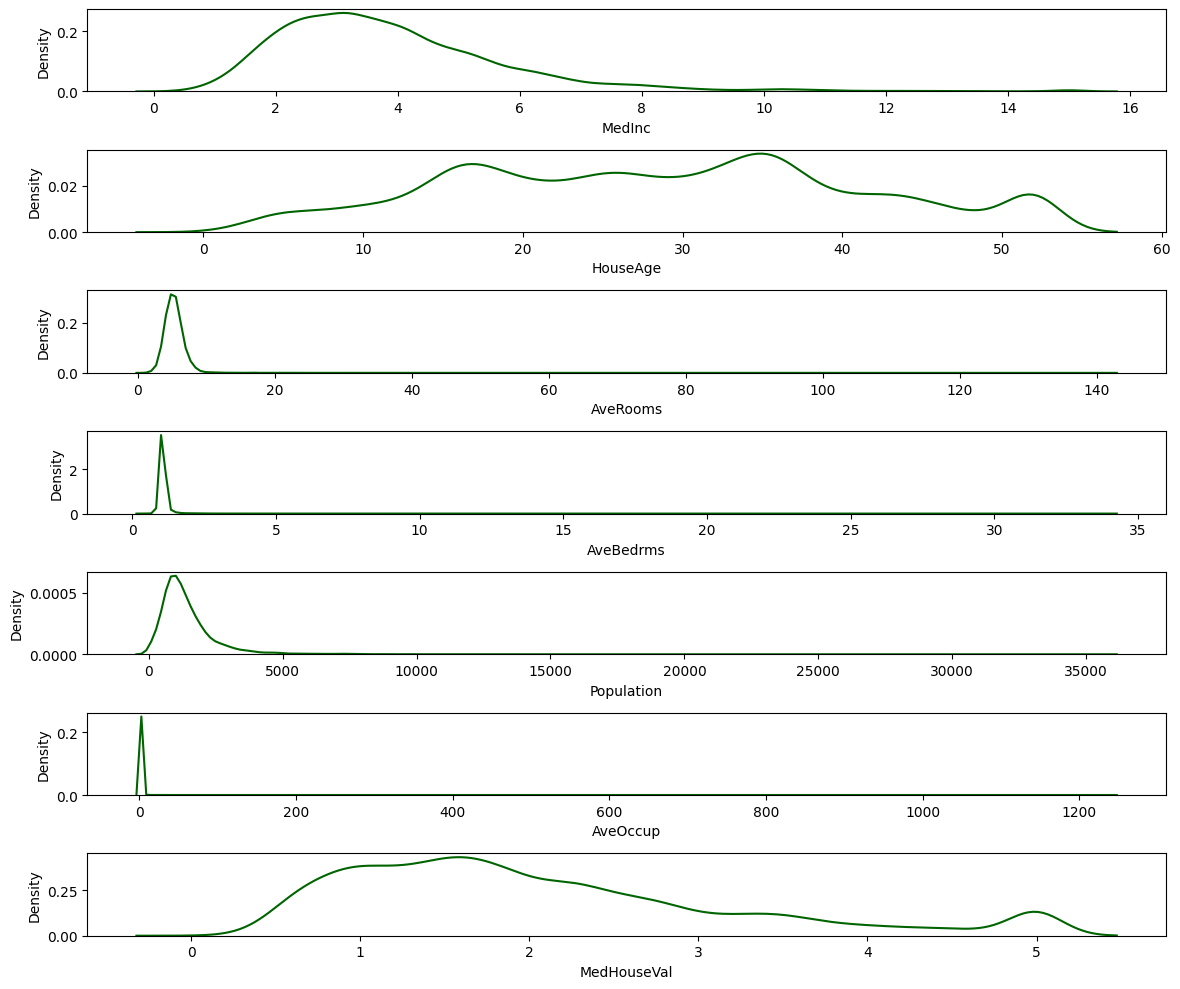

In [8]:
fig, axes = plt.subplots(ncols=1, nrows=7,figsize=(12,10))
axes = axes.flatten()

for index, column in enumerate(features_numeric_cols):
    
    sns.kdeplot(data=df,
                x=column,
                ax=axes[index],
                color="darkgreen")
    
plt.tight_layout()
plt.show()

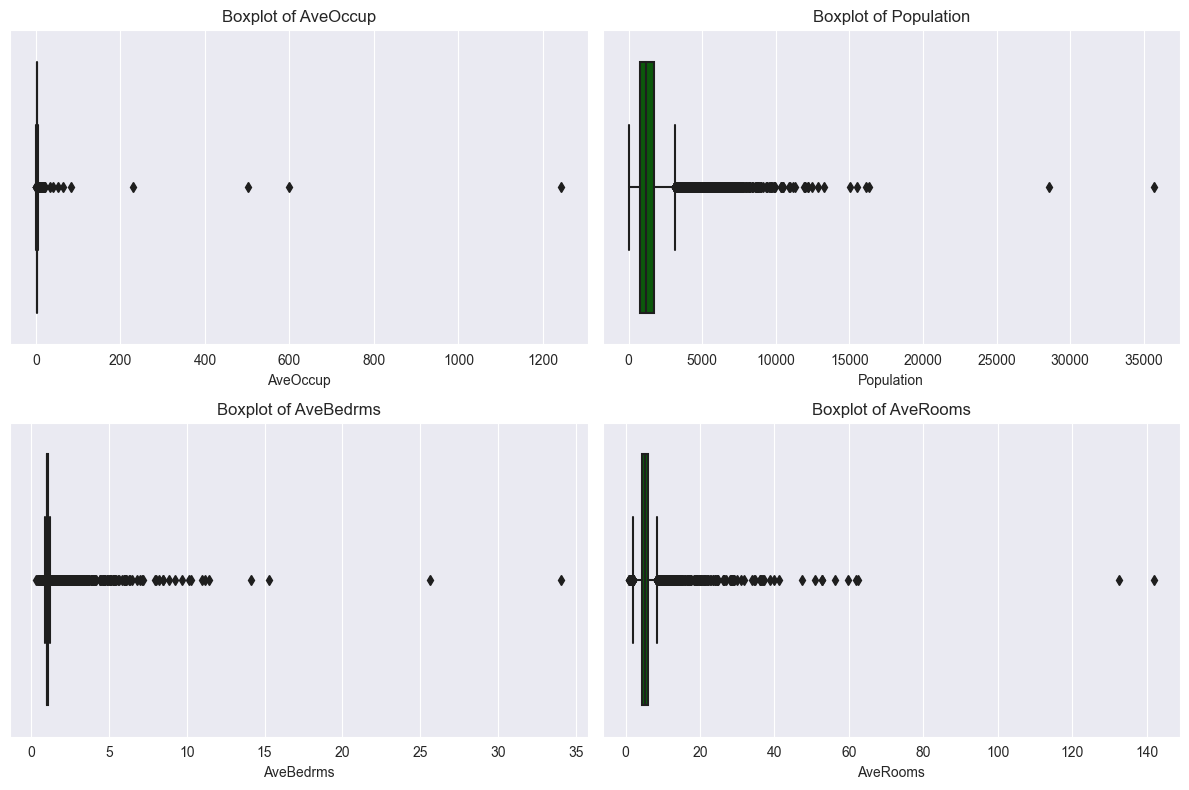

In [9]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,8))
axes = axes.flatten()

for index, column in enumerate(df[["AveOccup","Population","AveBedrms","AveRooms"]].columns):
    
    sns.boxplot(data=df,
                x=column,
                ax=axes[index],
                color="darkgreen")
    
    axes[index].set_title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

In [10]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [11]:
X = df.drop("MedHouseVal",axis=1)
y = df["MedHouseVal"]
X = sm.add_constant(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=123)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14447, 9)
X_test shape: (6193, 9)
y_train shape: (14447,)
y_test shape: (6193,)


In [13]:
for column in ["AveOccup","Population","AveBedrms","AveRooms"]:
    X_train[column] = winsorize(X_train[column], limits = (0.05,0.05))
    X_test[column] = winsorize(X_test[column], limits = (0.05,0.05))

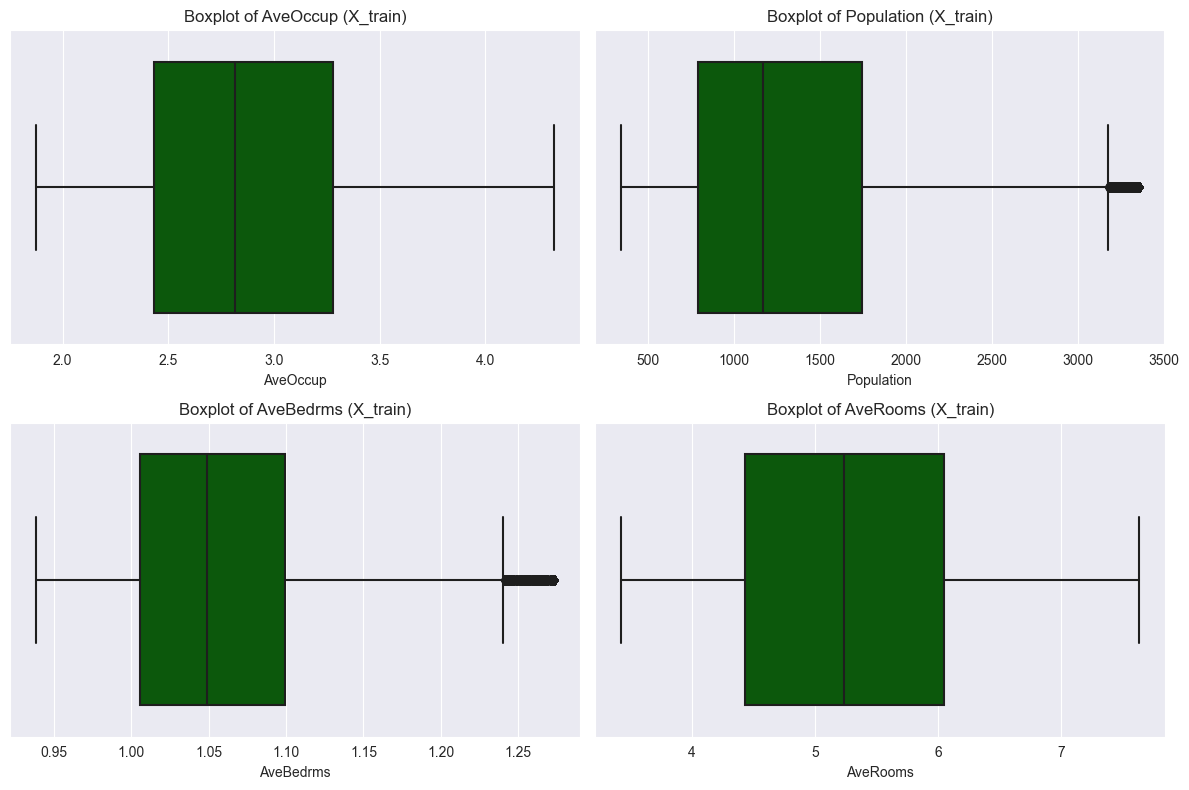

In [14]:
sns.set_style("darkgrid")

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,8))
axes = axes.flatten()

for index, column in enumerate(X_train[["AveOccup","Population","AveBedrms","AveRooms"]].columns):
    
    sns.boxplot(data=X_train,
                x=column,
                ax=axes[index],
                color="darkgreen")
    
    axes[index].set_title(f"Boxplot of {column} (X_train)")

plt.tight_layout()
plt.show()

In [15]:
X_train.head()

,const,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
12271,1.0,3.5255,21.0,5.694581,1.049261,2174.0,2.677340,34.00,-117.04
19605,1.0,1.9728,32.0,5.468208,1.144509,624.0,3.606936,37.55,-121.03
10600,1.0,6.9133,8.0,5.976471,1.026471,862.0,2.535294,33.68,-117.80
45,1.0,2.6768,52.0,4.335079,1.099476,718.0,1.879581,37.83,-122.26
2889,1.0,2.5083,52.0,5.373563,1.097701,1325.0,2.538314,35.39,-118.99


In [16]:
X_test.head()

,const,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
19121,1.0,3.7917,40.0,4.959799,1.030151,1039.0,2.610553,38.24,-122.64
20019,1.0,4.0217,9.0,5.804577,1.000000,1749.0,3.079225,36.09,-119.05
15104,1.0,4.0882,12.0,5.360360,1.070571,3171.0,4.341137,32.85,-116.98
3720,1.0,2.2377,27.0,3.455806,1.023207,3171.0,3.589662,34.20,-118.42
8938,1.0,4.4211,41.0,5.656904,1.165272,1047.0,2.190377,34.01,-118.47


In [17]:
lm_mod_winsorized = sm.OLS(y_train,X_train).fit()
print(lm_mod_winsorized.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3517.
Date:                Tue, 02 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:51:57   Log-Likelihood:                -14778.
No. Observations:               14447   AIC:                         2.957e+04
Df Residuals:                   14438   BIC:                         2.964e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.3891      0.755    -45.538      0.0

In [18]:
test_predict = lm_mod_winsorized.predict(X_test)
print(f"R^2: {round(r2_score(y_true = y_test, y_pred = test_predict),4)}")
print(f"MAE: {round(mean_absolute_error(y_true = y_test, y_pred = test_predict),4)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_true = y_test, y_pred = test_predict),4)}")

R^2: 0.6761
MAE: 0.4819
MAPE: 0.292


In [19]:
X_train_2,X_test_2,y_train_2,y_test_2 = train_test_split(X,y,train_size=0.7,random_state=123)
lm_mod_2 = sm.OLS(y_train_2,X_train_2).fit()
print(lm_mod_2.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     2761.
Date:                Tue, 02 Jan 2024   Prob (F-statistic):               0.00
Time:                        23:52:03   Log-Likelihood:                -15884.
No. Observations:               14447   AIC:                         3.179e+04
Df Residuals:                   14438   BIC:                         3.185e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.8554      0.790    -46.664      0.0

In [20]:
test_predict_2 = lm_mod_2.predict(X_test_2)
print(f"R^2: {round(r2_score(y_true = y_test_2, y_pred = test_predict_2),4)}")
print(f"MAE: {round(mean_absolute_error(y_true = y_test_2, y_pred = test_predict_2),4)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y_true = y_test_2, y_pred = test_predict_2),4)}")

R^2: 0.6094
MAE: 0.5288
MAPE: 0.3178


In [21]:
X_train = X_train.drop("const",axis=1)
X_test = X_test.drop("const",axis=1)

In [22]:
rf_mod = RandomForestRegressor(n_estimators=250,max_depth = 6,max_features=5,random_state=123)
rf_mod.fit(X_train,y_train)

RandomForestRegressor(max_depth=6, max_features=5, n_estimators=250,
                      random_state=123)

In [23]:
rf_mod.predict(X_test)

array([2.03973585, 1.79047347, 1.7323344 , ..., 2.99302159, 1.9921528 ,
       1.71071416])

In [94]:
print(f"Random Forest MAE: {round(mean_absolute_error(y_true = y_test, y_pred = rf_mod.predict(X_test)),4)}")
print(f"Random Forest MAPE: {round(mean_absolute_percentage_error(y_true = y_test, y_pred = rf_mod.predict(X_test)),4)}")
print(f"Random Forest R^2: {round(r2_score(y_true = y_test, y_pred = rf_mod.predict(X_test)),4)}")

Random Forest MAE: 0.4472
Random Forest MAPE: 0.2805
Random Forest R^2: 0.7104


In [25]:
mean_absolute_error(y_true = y_test, y_pred = rf_mod.predict(X_test))

0.44718906369048755

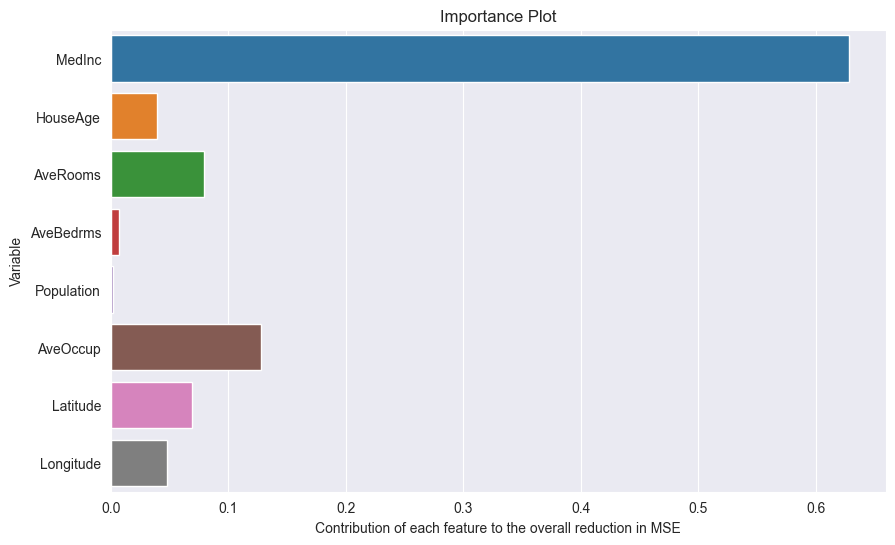

In [26]:
cols_list = X_train.columns.to_list()
importances = rf_mod.feature_importances_
importances_list = list(importances)

plt.figure(figsize=(10,6))
sns.barplot(y=cols_list,x=importances_list)
plt.title('Importance Plot')
plt.ylabel('Variable')
plt.xlabel('Contribution of each feature to the overall reduction in MSE')
plt.show()

In [84]:
rf_transf = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=250,max_depth = 6,max_features=5,random_state=123),
                                            func = np.log,
                                            inverse_func=np.exp)

rf_transf.fit(X_train, y_train)
rf_transf_pred = rf_transf.predict(X_test)

In [87]:
rf_transf_pred[0:5]

array([1.99838262, 1.59851798, 1.62207327, 1.68652202, 3.0491985 ])

In [91]:
print(f"RandomForestRegressor with log transformation: MAE {round(mean_absolute_error(y_true = y_test, y_pred = rf_transf_pred),4)}")
print(f"RandomForestRegressor with log transformation: MAPE {round(mean_absolute_percentage_error(y_true = y_test, y_pred = rf_transf_pred),4)}")
print(f"RandomForestRegressor with log transformation: R^2 {round(r2_score(y_true = y_test, y_pred = rf_transf_pred),4)}")

RandomForestRegressor with log transformation: MAE 0.4309
RandomForestRegressor with log transformation: MAPE 0.2334
RandomForestRegressor with log transformation: R^2 0.6968


In [38]:
std_scaler = StandardScaler()
X_train_scaled  = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.fit_transform(X_test)

knn_reg = KNeighborsRegressor(n_neighbors=3)

optimal_search = GridSearchCV(knn_reg,
                             param_grid={"n_neighbors":[3,4,5,6,7,8,9,10,11,12,13,14,15,16]},
                             cv=4,
                             scoring = "neg_mean_absolute_error")

optimal_search.fit(X_train_scaled,y_train)

GridSearchCV(cv=4, estimator=KNeighborsRegressor(n_neighbors=3),
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16]},
             scoring='neg_mean_absolute_error')

In [39]:
print(optimal_search.best_params_)
print(optimal_search.best_score_)

{'n_neighbors': 10}
-0.4343026097753365


In [40]:
kNN_reg_10_neighbors = KNeighborsRegressor(n_neighbors=10)
# uzupełnij o brakujace dane dotyczące zbioru uczącego:
kNN_reg_10_neighbors.fit(X_train_scaled,y_train)
kNN_reg_10_neighbors_test_pred = kNN_reg_10_neighbors.predict(X_test_scaled)

In [41]:
kNN_reg_10_neighbors_test_pred[0:5]

array([2.1571  , 0.9855  , 1.4517  , 1.843   , 3.602102])

In [62]:
print(f"kNN MAE: {round(mean_absolute_error(y_true = y_test, y_pred = kNN_reg_10_neighbors_test_pred),4)}")
print(f"kNN MAPE: {round(mean_absolute_percentage_error(y_true = y_test, y_pred = kNN_reg_10_neighbors_test_pred),4)}")
print(f"kNN R^2: {round(r2_score(y_true = y_test, y_pred = kNN_reg_10_neighbors_test_pred),4)}")

kNN MAE: 0.4252
kNN MAPE: 0.2542
kNN R^2: 0.7256


In [96]:
kNN_reg_transf = TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=10),
                                            func = np.log,
                                            inverse_func=np.exp)

kNN_reg_transf.fit(X_train_scaled, y_train)
kNN_reg_transf_pred = kNN_reg_transf.predict(X_test_scaled)

In [97]:
kNN_reg_transf_pred[0:5]

array([2.04695861, 0.97433687, 1.42537036, 1.78609496, 3.47743318])

In [98]:
print(f"kNN_transf MAE: {round(mean_absolute_error(y_true = y_test, y_pred = kNN_reg_transf_pred),4)}")
print(f"kNN_transf MAPE: {round(mean_absolute_percentage_error(y_true = y_test, y_pred = kNN_reg_transf_pred),4)}")
print(f"kNN transdf R^2: {round(r2_score(y_true =  y_test, y_pred = kNN_reg_transf_pred),4)}")

kNN_transf MAE: 0.4158
kNN_transf MAPE: 0.2324
kNN transdf R^2: 0.7213


In [100]:
final_metrics = pd.DataFrame({"model_type":["linear_regression",
               "linear_regression_winsorized",
               "random_forest_winsorized",
               "random_forest_winsorized_transformed",
               "kNN_winsorized",
               "kNN_winsorized_transformed"],
 "MAE":[round(mean_absolute_error(y_true = y_test_2, y_pred = test_predict_2),4),
        round(mean_absolute_error(y_true = y_test, y_pred = test_predict),4),
        round(mean_absolute_error(y_true = y_test, y_pred = rf_mod.predict(X_test)),4),
        round(mean_absolute_error(y_true = y_test, y_pred = rf_transf_pred),4),
        round(mean_absolute_error(y_true = y_test, y_pred = kNN_reg_10_neighbors_test_pred),4),
        round(mean_absolute_error(y_true = y_test, y_pred = kNN_reg_transf_pred),4)],
"MAPE": [round(mean_absolute_percentage_error(y_true = y_test_2, y_pred = test_predict_2),4),
         round(mean_absolute_percentage_error(y_true = y_test, y_pred = test_predict),4),
         round(mean_absolute_percentage_error(y_true = y_test, y_pred = rf_mod.predict(X_test)),4),
         round(mean_absolute_percentage_error(y_true = y_test, y_pred = rf_transf_pred),4),
         round(mean_absolute_percentage_error(y_true = y_test, y_pred = kNN_reg_10_neighbors_test_pred),4),
         round(mean_absolute_percentage_error(y_true = y_test, y_pred = kNN_reg_transf_pred),4)],
"R^2": [round(r2_score(y_true = y_test_2, y_pred = test_predict_2),4),
        round(r2_score(y_true = y_test, y_pred = test_predict),4),
        round(r2_score(y_true = y_test, y_pred = rf_mod.predict(X_test)),4),
        round(r2_score(y_true = y_test, y_pred = rf_transf_pred),4),
        round(r2_score(y_true = y_test, y_pred = kNN_reg_10_neighbors_test_pred),4),
        round(r2_score(y_true =  y_test, y_pred = kNN_reg_transf_pred),4)]})

In [103]:
final_metrics.sort_values("MAPE",ascending=True)

,model_type,MAE,MAPE,R^2
5,kNN_winsorized_transformed,0.4158,0.2324,0.7213
3,random_forest_winsorized_transformed,0.4309,0.2334,0.6968
4,kNN_winsorized,0.4252,0.2542,0.7256
2,random_forest_winsorized,0.4472,0.2805,0.7104
1,linear_regression_winsorized,0.4819,0.2920,0.6761
0,linear_regression,0.5288,0.3178,0.6094


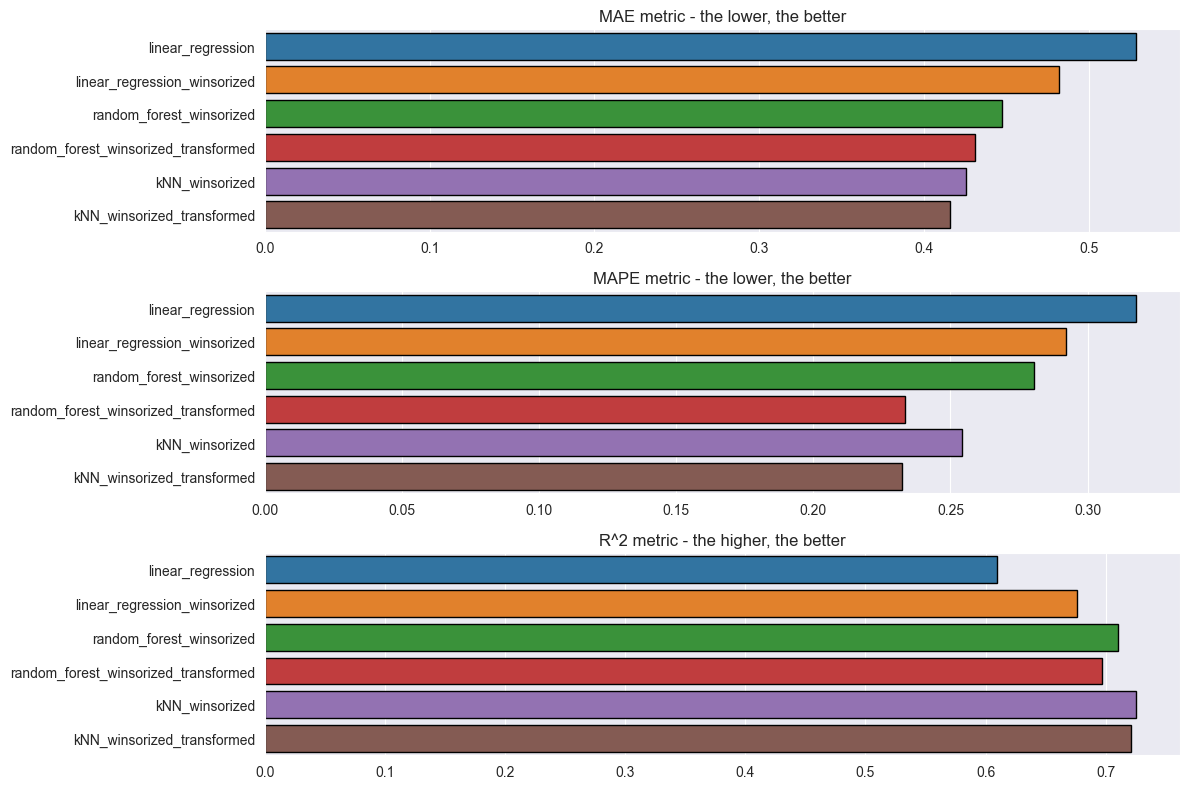

In [122]:
fig, axes = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
axes = axes.flatten()
model_type = final_metrics["model_type"].unique()

for index, column in enumerate(["MAE","MAPE","R^2"]):
    
    sns.barplot(data=final_metrics,
                y="model_type",
                x=column,
                ax=axes[index],
                edgecolor="black")
    
    axes[index].set_xlabel("")
    axes[index].set_ylabel("")

    if index < 2:
        axes[index].set_title(f"{column} metric - the lower, the better")
    else:
        axes[index].set_title(f"{column} metric - the higher, the better")

plt.tight_layout()
plt.show()